In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, roc_auc_score, precision_recall_curve, auc

rates = 2**np.arange(7)/80
print(rates)

[0.0125 0.025  0.05   0.1    0.2    0.4    0.8   ]


In [2]:
def get_inputs(sm):
    seq_len = 220
    sm = sm.split()
    if len(sm)>218:
        print('SMILES is too long ({:d})'.format(len(sm)))
        sm = sm[:109]+sm[-109:]
    ids = [vocab.stoi.get(token, unk_index) for token in sm]
    ids = [sos_index] + ids + [eos_index]
    seg = [1]*len(ids)
    padding = [pad_index]*(seq_len - len(ids))
    ids.extend(padding), seg.extend(padding)
    return ids, seg

def get_array(smiles):
    x_id, x_seg = [], []
    for sm in smiles:
        a,b = get_inputs(sm)
        x_id.append(a)
        x_seg.append(b)
    return torch.tensor(x_id), torch.tensor(x_seg)

# Smiles Transformer, RNN pre-training model

In [3]:
import torch
from pretrain_trfm import TrfmSeq2seq
from pretrain_rnn import RNNSeq2Seq
# from bert import BERT
from build_vocab import WordVocab
from utils import split

pad_index = 0
unk_index = 1
eos_index = 2
sos_index = 3
mask_index = 4

vocab = WordVocab.load_vocab('../data/vocab.pkl')

print(len(vocab))
trfm = TrfmSeq2seq(len(vocab), 256, len(vocab), 4)
trfm.load_state_dict(torch.load('.save/trfm_origin.pkl'))
trfm.eval()
print('Total parameters of Smiles Transformer model:', sum(p.numel() for p in trfm.parameters()))

hidden_size = 256
embed_size = 256


model = RNNSeq2Seq(len(vocab), embed_size, hidden_size, 3)
rnn = RNNSeq2Seq(len(vocab), 256, 256, 3)
rnn.load_state_dict(torch.load('.save/rnnenum_1_7000.pkl'))
rnn.eval()
print('Total parameters of RNN model:', sum(p.numel() for p in rnn.parameters()))

c:\users\anhtt\workingspace\pycharm\pytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


45
Total parameters of Smiles Transformer model: 4245037
Total parameters of RNN model: 4713517


In [4]:
def evaluate_classification(X, y, rate, n_repeats, model='lr'):
    roc_aucs, prc_aucs = np.empty(n_repeats), np.empty(n_repeats)
    for i in range(n_repeats):
        if model=='lr':
            clf = LogisticRegression(penalty='l2', solver='lbfgs', max_iter=5000)
        elif model=='rf':
            clf = RandomForestClassifier(n_estimators=10)
        elif model=='mlp':
            clf = MLPClassifier(max_iter=5000)
        else:
            raise ValueError('Model "{}" is invalid. Specify "ridge" or "rf".'.format(model))
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1-rate, stratify=y)
        clf.fit(X_train, y_train)
        y_score = clf.predict_proba(X_test)
        roc_aucs[i] = roc_auc_score(y_test, y_score[:,1])
        precision, recall, thresholds = precision_recall_curve(y_test, y_score[:,1])
        prc_aucs[i] = auc(recall, precision)
    ret = {}
    ret['roc_auc mean'] = np.mean(roc_aucs)
    ret['roc_auc std'] = np.std(roc_aucs)
    ret['prc_auc mean'] = np.mean(prc_aucs)
    ret['prc_auc std'] = np.std(prc_aucs)
    
    return ret

# BBBP dataset

In [5]:
df = pd.read_csv('data/bbbp.csv')
L = len(df)
print(df.shape)
df.head()
x_split = [split(sm) for sm in df['smiles'].values]
xid, xseg = get_array(x_split)

(2050, 4)
SMILES is too long (256)
SMILES is too long (239)
SMILES is too long (258)
SMILES is too long (380)
SMILES is too long (332)


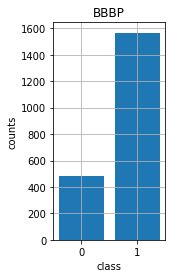

In [6]:
keys = ['0', '1']
bottom = df.groupby('p_np').count()['smiles'].values
plt.figure(figsize=(2,4))
plt.bar(keys, bottom)
plt.xlabel('class')
plt.ylabel('counts')
plt.title('BBBP')
plt.grid()
plt.show()

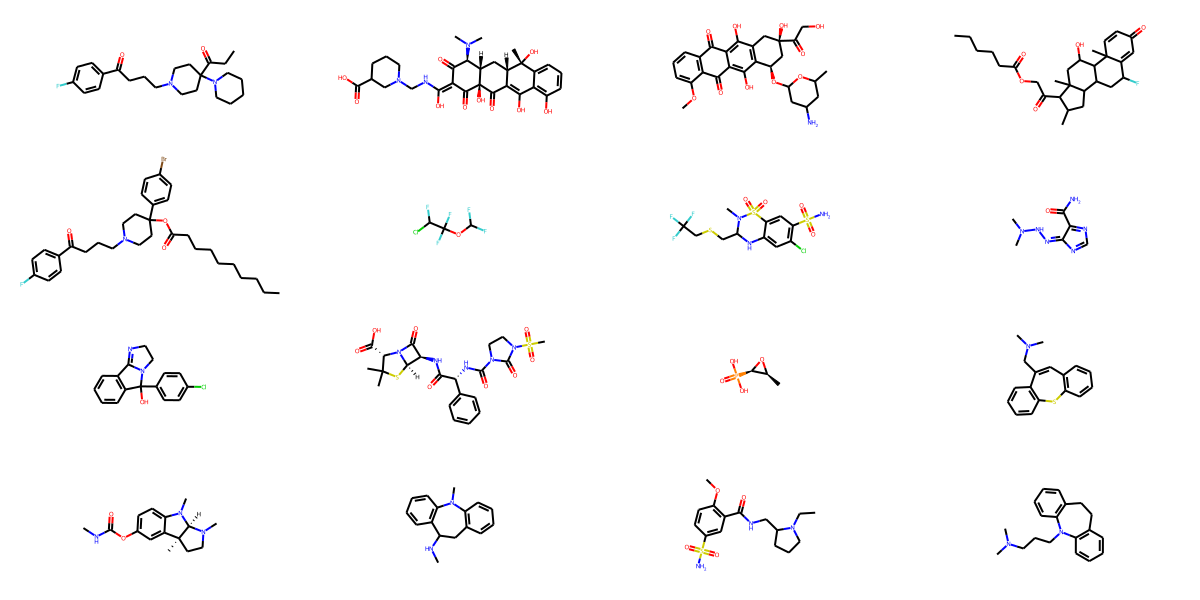

In [7]:
from rdkit.Chem import Draw, MolFromSmiles, MolToSmiles
rands = np.random.choice(L, 16, replace=False)
smiles = df.iloc[rands]['smiles'].values
mols = []
for s in smiles:
    if s is None:
        continue
    mol = MolFromSmiles(s)
    if mol is not None:
        mols.append(mol)
Draw.MolsToGridImage(mols, molsPerRow=4, subImgSize=(300,150))

# Classification without Pre-training settings

Logistic Regression (LR)

In [8]:
scores = []
for rate in rates:
    score_dic = evaluate_classification(xid, df['p_np'].values, rate, 20, model='lr')
    print(rate, score_dic)
    scores.append([score_dic['roc_auc mean'], score_dic['roc_auc std']])
scores_LR = np.array(scores)
print("Average results: ", np.mean(scores_LR[:, 0]), np.mean(scores_LR[:, 1]))

0.0125 {'roc_auc mean': 0.55466484108798, 'roc_auc std': 0.07283786089989501, 'prc_auc mean': 0.7749937376946574, 'prc_auc std': 0.04086416717327699}
0.025 {'roc_auc mean': 0.5911599887729129, 'roc_auc std': 0.06737293068091235, 'prc_auc mean': 0.7902094073457759, 'prc_auc std': 0.0340166497548622}
0.05 {'roc_auc mean': 0.5895224383313507, 'roc_auc std': 0.037607875725323474, 'prc_auc mean': 0.7907171889635932, 'prc_auc std': 0.02094737354220249}
0.1 {'roc_auc mean': 0.5800163854243092, 'roc_auc std': 0.03643271059882773, 'prc_auc mean': 0.7824227286856404, 'prc_auc std': 0.024997432498760897}
0.2 {'roc_auc mean': 0.6097947707233227, 'roc_auc std': 0.027763189890897655, 'prc_auc mean': 0.7934226069464002, 'prc_auc std': 0.01776797823290371}
0.4 {'roc_auc mean': 0.6691375641966252, 'roc_auc std': 0.01651384759308084, 'prc_auc mean': 0.8252939319711897, 'prc_auc std': 0.011985152066950559}
0.8 {'roc_auc mean': 0.7245331181449887, 'roc_auc std': 0.019288731485376232, 'prc_auc mean': 0.861

Random Forest Classifier (RF)

In [9]:
scores = []
for rate in rates:
    score_dic = evaluate_classification(xid, df['p_np'].values, rate, 20, model='rf')
    print(rate, score_dic)
    scores.append([score_dic['roc_auc mean'], score_dic['roc_auc std']])
scores_RF = np.array(scores)
print("Average results: ", np.mean(scores_RF[:, 0]), np.mean(scores_RF[:, 1]))

0.0125 {'roc_auc mean': 0.6764012467564829, 'roc_auc std': 0.03392584842967628, 'prc_auc mean': 0.8699657337285913, 'prc_auc std': 0.01631081669328097}
0.025 {'roc_auc mean': 0.7031697068729783, 'roc_auc std': 0.032546366398277043, 'prc_auc mean': 0.8835700298894766, 'prc_auc std': 0.014959899318685658}
0.05 {'roc_auc mean': 0.7455789442110701, 'roc_auc std': 0.018965493991299938, 'prc_auc mean': 0.9006622469813002, 'prc_auc std': 0.009907632909300548}
0.1 {'roc_auc mean': 0.7819727724790088, 'roc_auc std': 0.016878187310951833, 'prc_auc mean': 0.9152701673148254, 'prc_auc std': 0.008541354001102308}
0.2 {'roc_auc mean': 0.831396784176645, 'roc_auc std': 0.018020583710787616, 'prc_auc mean': 0.9373030220313568, 'prc_auc std': 0.00831138608135843}
0.4 {'roc_auc mean': 0.8706511371973589, 'roc_auc std': 0.012704506312983473, 'prc_auc mean': 0.9535489278677648, 'prc_auc std': 0.00611852948027705}
0.8 {'roc_auc mean': 0.9048746747472085, 'roc_auc std': 0.015275424778852036, 'prc_auc mean':

Multi-layer Perceptron Classifier (MLP)

In [10]:
scores = []
for rate in rates:
    score_dic = evaluate_classification(xid, df['p_np'].values, rate, 20, model='mlp')
    print(rate, score_dic)
    scores.append([score_dic['roc_auc mean'], score_dic['roc_auc std']])
scores_MLP = np.array(scores)
print("Average results: ", np.mean(scores_MLP[:, 0]), np.mean(scores_MLP[:, 1]))

0.0125 {'roc_auc mean': 0.5682912014691303, 'roc_auc std': 0.08769705484076992, 'prc_auc mean': 0.777639805581962, 'prc_auc std': 0.04545547175395832}
0.025 {'roc_auc mean': 0.5576252487188893, 'roc_auc std': 0.06974070961215834, 'prc_auc mean': 0.7685820216931316, 'prc_auc std': 0.039696202832236446}
0.05 {'roc_auc mean': 0.6129236770448797, 'roc_auc std': 0.036144550416501456, 'prc_auc mean': 0.8016724328768866, 'prc_auc std': 0.02453211694158011}
0.1 {'roc_auc mean': 0.6497039210891008, 'roc_auc std': 0.031663115927338316, 'prc_auc mean': 0.819078057091685, 'prc_auc std': 0.015135360145312428}
0.2 {'roc_auc mean': 0.711009123137566, 'roc_auc std': 0.026987156945776906, 'prc_auc mean': 0.8540466959449116, 'prc_auc std': 0.017180564962744924}
0.4 {'roc_auc mean': 0.7486030814380044, 'roc_auc std': 0.025933822804987818, 'prc_auc mean': 0.8797351250199252, 'prc_auc std': 0.018264725681796466}
0.8 {'roc_auc mean': 0.815300879417674, 'roc_auc std': 0.02918476598917008, 'prc_auc mean': 0.9

Classification evaluation

C:\Users\anhtt\AppData\Local\Temp\ipykernel_8896\149481803.py:24: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


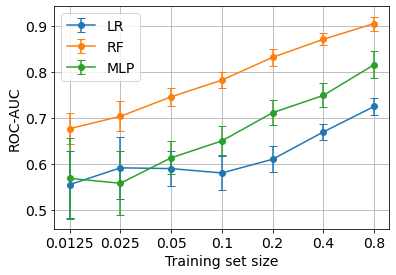

In [11]:
y_LR = np.transpose(scores_LR)[0, :]
err_LR = np.transpose(scores_LR)[1, :]

y_RF = np.transpose(scores_RF)[0, :]
err_RF = np.transpose(scores_RF)[1, :]

y_MLP = np.transpose(scores_MLP)[0, :]
err_MLP = np.transpose(scores_MLP)[1, :]

fig = plt.figure(figsize=(6,9))
plt.rcParams['font.size'] = 14
x=['0.0125','0.025', '0.05',   '0.1',    '0.2',    '0.4',    '0.8']
ax = fig.add_subplot(2, 1, 1)

ax.errorbar(x, y_LR ,yerr=err_LR, fmt='-o', label='LR', capsize=4)
ax.errorbar(x, y_RF ,yerr=err_RF, fmt='-o', label='RF', capsize=4)
ax.errorbar(x, y_MLP ,yerr=err_MLP, fmt='-o', label='MLP', capsize=4)

ax.set_xticks(x)
ax.set_xlabel('Training set size')
ax.set_ylabel('ROC-AUC')
ax.legend()
ax.grid()
fig.show()

# Pre-training SMILES TRANSFORMER model

In [12]:
X_sf = trfm.encode(torch.t(xid))
print(X_sf.shape)

There are 2050 molecules. It will take a little time.
(2050, 1024)


ST + Logistic Regression

In [13]:
scores = []
for rate in rates:
    score_dic = evaluate_classification(X_sf, df['p_np'].values, rate, 20, model='lr')
    print(rate, score_dic)
    scores.append([score_dic['roc_auc mean'], score_dic['roc_auc std']])
scores_sf_LR = np.array(scores)
print("Average results: ", np.mean(scores_sf_LR[:, 0]), np.mean(scores_sf_LR[:, 1]))

0.0125 {'roc_auc mean': 0.8345192823363072, 'roc_auc std': 0.051374532770716554, 'prc_auc mean': 0.9390297062683611, 'prc_auc std': 0.024309981369718552}
0.025 {'roc_auc mean': 0.8624207990129056, 'roc_auc std': 0.023199221453206766, 'prc_auc mean': 0.9501131184719076, 'prc_auc std': 0.011283243827671105}
0.05 {'roc_auc mean': 0.8855174694308735, 'roc_auc std': 0.0165202828590405, 'prc_auc mean': 0.9587521342363295, 'prc_auc std': 0.009617261912410685}
0.1 {'roc_auc mean': 0.8991283932501835, 'roc_auc std': 0.009951559866953025, 'prc_auc mean': 0.964518518163865, 'prc_auc std': 0.005224711471481884}
0.2 {'roc_auc mean': 0.9142104849972317, 'roc_auc std': 0.009453666206720508, 'prc_auc mean': 0.9701443153352913, 'prc_auc std': 0.0041989039904042295}
0.4 {'roc_auc mean': 0.9271702127659575, 'roc_auc std': 0.006703027365910963, 'prc_auc mean': 0.9750412558837109, 'prc_auc std': 0.003453586443155521}
0.8 {'roc_auc mean': 0.9355867725041994, 'roc_auc std': 0.013554867723258958, 'prc_auc mea

ST + Random Forest Classifier

In [14]:
scores = []
for rate in rates:
    score_dic = evaluate_classification(X_sf, df['p_np'].values, rate, 20, model='rf')
    print(rate, score_dic)
    scores.append([score_dic['roc_auc mean'], score_dic['roc_auc std']])
scores_sf_RF = np.array(scores)
print("Average results: ", np.mean(scores_sf_RF[:, 0]), np.mean(scores_sf_RF[:, 1]))

0.0125 {'roc_auc mean': 0.7866027172411552, 'roc_auc std': 0.04780203916103574, 'prc_auc mean': 0.9226177431612713, 'prc_auc std': 0.02289598370135899}
0.025 {'roc_auc mean': 0.8325168684207602, 'roc_auc std': 0.023620192062764896, 'prc_auc mean': 0.942654763773336, 'prc_auc std': 0.008803765532284142}
0.05 {'roc_auc mean': 0.86380932941791, 'roc_auc std': 0.01140458702696873, 'prc_auc mean': 0.952708408182896, 'prc_auc std': 0.0047202635285118165}
0.1 {'roc_auc mean': 0.8883548137278877, 'roc_auc std': 0.008802519297733747, 'prc_auc mean': 0.962462998221033, 'prc_auc std': 0.003569127061635607}
0.2 {'roc_auc mean': 0.907372935105073, 'roc_auc std': 0.007315882265477006, 'prc_auc mean': 0.9692937573916925, 'prc_auc std': 0.002664776466344532}
0.4 {'roc_auc mean': 0.9183139214966985, 'roc_auc std': 0.007460604576078564, 'prc_auc mean': 0.9728063477073838, 'prc_auc std': 0.0029179873415911906}
0.8 {'roc_auc mean': 0.9309401864233722, 'roc_auc std': 0.013653083703877236, 'prc_auc mean': 0

ST + Multi-layer Perceptron Classifier (MLP)

In [15]:
scores = []
for rate in rates:
    score_dic = evaluate_classification(X_sf, df['p_np'].values, rate, 20, model='mlp')
    print(rate, score_dic)
    scores.append([score_dic['roc_auc mean'], score_dic['roc_auc std']])
scores_sf_MLP = np.array(scores)
print("Average results: ", np.mean(scores_sf_MLP[:, 0]), np.mean(scores_sf_MLP[:, 1]))

0.0125 {'roc_auc mean': 0.8430216306697218, 'roc_auc std': 0.039050631693924025, 'prc_auc mean': 0.943900821476013, 'prc_auc std': 0.01778048824669838}
0.025 {'roc_auc mean': 0.8517188351063238, 'roc_auc std': 0.04373553453395345, 'prc_auc mean': 0.9454460261656944, 'prc_auc std': 0.02102136132144473}
0.05 {'roc_auc mean': 0.8858895517015851, 'roc_auc std': 0.01616977025408645, 'prc_auc mean': 0.9596960534384922, 'prc_auc std': 0.00787986607938439}
0.1 {'roc_auc mean': 0.9080145512350206, 'roc_auc std': 0.012408241632743254, 'prc_auc mean': 0.968600288088503, 'prc_auc std': 0.00548941138969347}
0.2 {'roc_auc mean': 0.9250916239019593, 'roc_auc std': 0.006947495891875233, 'prc_auc mean': 0.9751788431313587, 'prc_auc std': 0.003012445228127637}
0.4 {'roc_auc mean': 0.9334824834922966, 'roc_auc std': 0.004742056183423173, 'prc_auc mean': 0.9781569724579015, 'prc_auc std': 0.0015714865757307382}
0.8 {'roc_auc mean': 0.9420028984552552, 'roc_auc std': 0.012628237670826986, 'prc_auc mean': 0

SMILES TRANSFORMER evaluation

C:\Users\anhtt\AppData\Local\Temp\ipykernel_8896\56411120.py:24: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


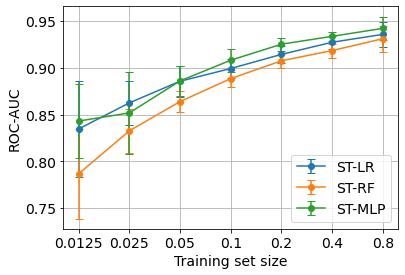

In [16]:
y_sf_LR = np.transpose(scores_sf_LR)[0, :]
err_sf_LR = np.transpose(scores_sf_LR)[1, :]

y_sf_RF = np.transpose(scores_sf_RF)[0, :]
err_sf_RF = np.transpose(scores_sf_RF)[1, :]

y_sf_MLP = np.transpose(scores_sf_MLP)[0, :]
err_sf_MLP = np.transpose(scores_sf_MLP)[1, :]

fig = plt.figure(figsize=(6,9))
plt.rcParams['font.size'] = 14
x=['0.0125','0.025', '0.05',   '0.1',    '0.2',    '0.4',    '0.8']
ax = fig.add_subplot(2, 1, 1)

ax.errorbar(x, y_sf_LR ,yerr=err_sf_LR, fmt='-o', label='ST-LR', capsize=4)
ax.errorbar(x, y_sf_RF ,yerr=err_sf_RF, fmt='-o', label='ST-RF', capsize=4)
ax.errorbar(x, y_sf_MLP ,yerr=err_sf_MLP, fmt='-o', label='ST-MLP', capsize=4)

ax.set_xticks(x)
ax.set_xlabel('Training set size')
ax.set_ylabel('ROC-AUC')
ax.legend()
ax.grid()
fig.show()

# Pre-training RNN model

In [17]:
X_rnn = rnn.encode(torch.t(xid))
print(X_rnn.shape)

There are 2050 molecules. It will take a little time.
(2050, 1024)


RNN + Logistic Regression

In [18]:
scores = []
for rate in rates:
    score_dic = evaluate_classification(X_rnn, df['p_np'].values, rate, 20, model='lr')
    print(rate, score_dic)
    scores.append([score_dic['roc_auc mean'], score_dic['roc_auc std']])
scores_rnn_LR = np.array(scores)
print("Average results: ", np.mean(scores_rnn_LR[:, 0]), np.mean(scores_rnn_LR[:, 1]))

0.0125 {'roc_auc mean': 0.7771942155699649, 'roc_auc std': 0.06763479781705409, 'prc_auc mean': 0.9045610411407067, 'prc_auc std': 0.045080007718062386}
0.025 {'roc_auc mean': 0.8298493235957803, 'roc_auc std': 0.035062618589228066, 'prc_auc mean': 0.9230053973772568, 'prc_auc std': 0.02727876975099649}
0.05 {'roc_auc mean': 0.8606641880690787, 'roc_auc std': 0.03056021920586986, 'prc_auc mean': 0.9415898499461808, 'prc_auc std': 0.0248540275927696}
0.1 {'roc_auc mean': 0.8976073204532484, 'roc_auc std': 0.010930054551553948, 'prc_auc mean': 0.962506124279418, 'prc_auc std': 0.007330902471219481}
0.2 {'roc_auc mean': 0.9203155085074911, 'roc_auc std': 0.005884236718385985, 'prc_auc mean': 0.9721853784431103, 'prc_auc std': 0.003704399891705398}
0.4 {'roc_auc mean': 0.9356076669112253, 'roc_auc std': 0.0065503368751423695, 'prc_auc mean': 0.9798107917024966, 'prc_auc std': 0.0031227743402800906}
0.8 {'roc_auc mean': 0.9476252429103125, 'roc_auc std': 0.008952315955131946, 'prc_auc mean'

RNN + Random Forest Classifier

In [19]:
scores = []
for rate in rates:
    score_dic = evaluate_classification(X_rnn, df['p_np'].values, rate, 20, model='rf')
    print(rate, score_dic)
    scores.append([score_dic['roc_auc mean'], score_dic['roc_auc std']])
scores_rnn_RF = np.array(scores)
print("Average results: ", np.mean(scores_rnn_RF[:, 0]), np.mean(scores_rnn_RF[:, 1]))

0.0125 {'roc_auc mean': 0.7542153871364417, 'roc_auc std': 0.040130196259291914, 'prc_auc mean': 0.9091403403867014, 'prc_auc std': 0.018834824736277303}
0.025 {'roc_auc mean': 0.7854663062327009, 'roc_auc std': 0.03628798319317068, 'prc_auc mean': 0.9232744282796925, 'prc_auc std': 0.01757834259613696}
0.05 {'roc_auc mean': 0.8272500881555518, 'roc_auc std': 0.02804477142836616, 'prc_auc mean': 0.9417123059786601, 'prc_auc std': 0.011728245400876598}
0.1 {'roc_auc mean': 0.8768576261514633, 'roc_auc std': 0.009652290222580576, 'prc_auc mean': 0.9597154851746572, 'prc_auc std': 0.0033690630076357734}
0.2 {'roc_auc mean': 0.9028855847815487, 'roc_auc std': 0.008726466120467624, 'prc_auc mean': 0.9685918323748892, 'prc_auc std': 0.003163560864101064}
0.4 {'roc_auc mean': 0.9261210564930302, 'roc_auc std': 0.008353631815609594, 'prc_auc mean': 0.9764315515243291, 'prc_auc std': 0.003205701656127142}
0.8 {'roc_auc mean': 0.9371817463192913, 'roc_auc std': 0.01262716956850234, 'prc_auc mean

RNN + Multi-layer Perceptron Classifier (MLP)

In [20]:
scores = []
for rate in rates:
    score_dic = evaluate_classification(X_rnn, df['p_np'].values, rate, 20, model='mlp')
    print(rate, score_dic)
    scores.append([score_dic['roc_auc mean'], score_dic['roc_auc std']])
scores_rnn_MLP = np.array(scores)
print("Average results: ", np.mean(scores_rnn_MLP[:, 0]), np.mean(scores_rnn_MLP[:, 1]))

0.0125 {'roc_auc mean': 0.780148592354238, 'roc_auc std': 0.043183782107901324, 'prc_auc mean': 0.9084908092445124, 'prc_auc std': 0.02698470804703075}
0.025 {'roc_auc mean': 0.8273762032992075, 'roc_auc std': 0.02328194249953803, 'prc_auc mean': 0.9282536972700353, 'prc_auc std': 0.019603963021451624}
0.05 {'roc_auc mean': 0.8642158325907783, 'roc_auc std': 0.025150115443300702, 'prc_auc mean': 0.9425761244682211, 'prc_auc std': 0.020953259682306803}
0.1 {'roc_auc mean': 0.8921629982880901, 'roc_auc std': 0.014850362881896846, 'prc_auc mean': 0.9604131233413209, 'prc_auc std': 0.010308600361976922}
0.2 {'roc_auc mean': 0.919186685507929, 'roc_auc std': 0.00789307408269095, 'prc_auc mean': 0.9729886729599327, 'prc_auc std': 0.0038176522920392764}
0.4 {'roc_auc mean': 0.936764765223771, 'roc_auc std': 0.005285180303420687, 'prc_auc mean': 0.9795255627573496, 'prc_auc std': 0.002469116036613796}
0.8 {'roc_auc mean': 0.9504281808899575, 'roc_auc std': 0.008572210201649845, 'prc_auc mean':

# Pre-training RNN Evaluation

C:\Users\anhtt\AppData\Local\Temp\ipykernel_8896\1491995531.py:24: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


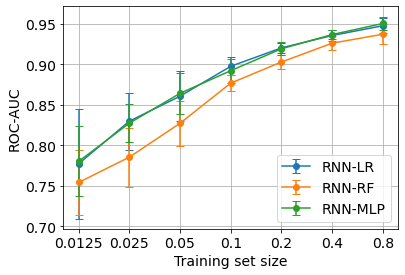

In [21]:
y_rnn_LR = np.transpose(scores_rnn_LR)[0, :]
err_rnn_LR = np.transpose(scores_rnn_LR)[1, :]

y_rnn_RF = np.transpose(scores_rnn_RF)[0, :]
err_rnn_RF = np.transpose(scores_rnn_RF)[1, :]

y_rnn_MLP = np.transpose(scores_rnn_MLP)[0, :]
err_rnn_MLP = np.transpose(scores_rnn_MLP)[1, :]

fig = plt.figure(figsize=(6,9))
plt.rcParams['font.size'] = 14
x=['0.0125','0.025', '0.05',   '0.1',    '0.2',    '0.4',    '0.8']
ax = fig.add_subplot(2, 1, 1)

ax.errorbar(x, y_rnn_LR ,yerr=err_rnn_LR, fmt='-o', label='RNN-LR', capsize=4)
ax.errorbar(x, y_rnn_RF ,yerr=err_rnn_RF, fmt='-o', label='RNN-RF', capsize=4)
ax.errorbar(x, y_rnn_MLP ,yerr=err_rnn_MLP, fmt='-o', label='RNN-MLP', capsize=4)

ax.set_xticks(x)
ax.set_xlabel('Training set size')
ax.set_ylabel('ROC-AUC')
ax.legend()
ax.grid()
fig.show()

# Classification evaluation with Pre-training Smiles Transformer, RNN and without pre-training

C:\Users\anhtt\AppData\Local\Temp\ipykernel_8896\766386080.py:24: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


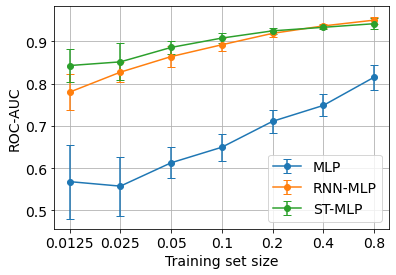

In [22]:
y_MLP = np.transpose(scores_MLP)[0, :]
err_MLP = np.transpose(scores_MLP)[1, :]

y_rnn_MLP = np.transpose(scores_rnn_MLP)[0, :]
err_rnn_MLP = np.transpose(scores_rnn_MLP)[1, :]

y_sf_MLP = np.transpose(scores_sf_MLP)[0, :]
err_sf_MLP = np.transpose(scores_sf_MLP)[1, :]

fig = plt.figure(figsize=(6,9))
plt.rcParams['font.size'] = 14
x=['0.0125','0.025', '0.05',   '0.1',    '0.2',    '0.4',    '0.8']
ax = fig.add_subplot(2, 1, 1)

ax.errorbar(x, y_MLP ,yerr=err_MLP, fmt='-o', label='MLP', capsize=4)
ax.errorbar(x, y_rnn_MLP ,yerr=err_rnn_MLP, fmt='-o', label='RNN-MLP', capsize=4)
ax.errorbar(x, y_sf_MLP ,yerr=err_sf_MLP, fmt='-o', label='ST-MLP', capsize=4)

ax.set_xticks(x)
ax.set_xlabel('Training set size')
ax.set_ylabel('ROC-AUC')
ax.legend()
ax.grid()
fig.show()

# Visualization of the Latent Space

In [23]:
from sklearn.manifold import TSNE
X_reduced = TSNE(n_components=2, random_state=0).fit_transform(X_sf)

c:\users\anhtt\workingspace\pycharm\pytorch\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\users\anhtt\workingspace\pycharm\pytorch\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [24]:
from sklearn.neighbors import NearestNeighbors
nn = NearestNeighbors(metric='euclidean').fit(X_reduced)
xs = np.linspace(-45, 60, 12)
ys = np.linspace(-40, 10, 12)
ids = []
pts = []
for x,y in zip(xs, ys):
    _, result = nn.kneighbors([[x, y]], n_neighbors=1)
    ids.append(result[0, 0])
    pts.append(X_reduced[result[0, 0]])
pts = np.array(pts)

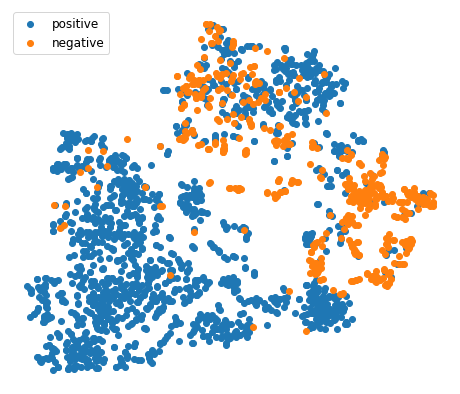

In [25]:
fig = plt.figure(figsize=(8,7))
plt.rcParams['font.size'] = 14
plt.rcParams['font.size'] = 12
plt.scatter(X_reduced[df['p_np']==1][:,0], X_reduced[df['p_np']==1][:,1], label='positive', marker='o')
plt.scatter(X_reduced[df['p_np']==0][:,0], X_reduced[df['p_np']==0][:,1], label='negative', marker='o')
plt.axis('off')
# for i in range(12):
#     plt.scatter(pts[i,0], pts[i,1], c='r', marker='${}$'.format(i), s=200*(1+i//10))
plt.legend(loc='upper left')
plt.savefig('bbbp.png', dpi=300)
plt.show()